# Object Detection

General pipeline is based on torchvision tutorial:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [3]:
# Install pycocotools
# !sh installPycocotools.sh

In [4]:
import os
import pickle
import torch
import json
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import numpy as np
from torch import Tensor
import utils
from PIL import Image
import transforms as T
from tqdm import tqdm
from torch import nn

## Helper functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [5]:
# Download TorchVision repo to use some files from
# references/detection
#! sh getHelperFunction.sh

In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def _load_json(path_list_idx):
    with open(path_list_idx, 'r') as file:
        data = json.load(file)
    return data

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
# Note that we do not need to add a mean/std normalization
# nor image rescaling in the data transforms, as those are
# handled internally by the Mask R-CNN model.

def get_ground_truths(train_img_path_list,anno_data):

    bboxes,total_bboxes = [],[]
    labels,total_labels = [],[]
    classes =  {'bus':0, 'traffic light':1, 'traffic sign':2, 'person':3, 'bike':4, 'truck':5, 'motor':6, 'car':7, 
            'train':8,'rider':9,'drivable area':10,'lane':11}

    for i in tqdm(range(len(train_img_path_list))):
        for j in range(len(anno_data[i]['labels'])):
            if 'box2d' in anno_data[i]['labels'][j]:
                xmin = anno_data[i]['labels'][j]['box2d']['x1']
                ymin = anno_data[i]['labels'][j]['box2d']['y1']
                xmax = anno_data[i]['labels'][j]['box2d']['x2']
                ymax = anno_data[i]['labels'][j]['box2d']['y2']
                bbox = [xmin,ymin,xmax,ymax]
                category = anno_data[i]['labels'][j]['category']
                cls = classes[category]

                bboxes.append(bbox)
                labels.append(cls)

        total_bboxes.append(Tensor(bboxes))
        total_labels.append(Tensor(labels))
        bboxes=[]
        labels=[]

    return total_bboxes,total_labels


Bad key "text.kerning_factor" on line 4 in
/home/ruslan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


In [7]:
bdd_path = '/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/'

root_img_path = os.path.join(bdd_path, 'images','100k')
root_anno_path = os.path.join(bdd_path, 'labels')

train_img_path = root_img_path+'/train/'
val_img_path = root_img_path+'/val/'

train_anno_json_path = root_anno_path+'/bdd100k_labels_images_train.json'
val_anno_json_path = root_anno_path+'/bdd100k_labels_images_val.json'

with open("datalists/bdd100k_train_images_path.txt", "rb") as fp:
    train_img_path_list = pickle.load(fp)
with open("datalists/bdd100k_val_images_path.txt", "rb") as fp:
    val_img_path_list = pickle.load(fp)

In [8]:
class BerkeleyDD(torch.utils.data.Dataset):
    def __init__(self, img_path, anno_json_path, transforms=None):
        super(BerkeleyDD, self).__init__()
        self.img_path = img_path
        self.anno_data = _load_json(anno_json_path)
        self.total_bboxes_list,self.total_labels_list = get_ground_truths(self.img_path, self.anno_data)
        self.transforms = transforms
        self.classes =  {'bus':0, 'traffic light':1, 'traffic sign':2,
                         'person':3, 'bike':4, 'truck':5, 'motor':6,
                         'car':7, 'train':8, 'rider':9,
                         'drivable area':10,'lane':11}

    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self,idx):
        img_path = self.img_path[idx]
        img = Image.open(img_path).convert("RGB")
        
        labels = self.total_labels_list[idx]
        bboxes = self.total_bboxes_list[idx]
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        
        img_id = Tensor([idx])
        iscrowd = torch.zeros(len(bboxes,), dtype=torch.int64)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels.type(torch.int64)
        target["image_id"] = img_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [9]:
print("Loading files")
batch_size = 4

dataset_train = BerkeleyDD(train_img_path_list[:500], train_anno_json_path, get_transform(train=True))
dataloader_train =  torch.utils.data.DataLoader(dataset_train,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=4,
                                  collate_fn=utils.collate_fn)

dataset_val = BerkeleyDD(val_img_path_list[:100], val_anno_json_path, get_transform(train=False))
dataloader_val =  torch.utils.data.DataLoader(dataset_val,
                                  batch_size=1,
                                  shuffle=False,
                                  num_workers=4,
                                  collate_fn=utils.collate_fn)

Loading files


100%|██████████| 100/100 [00:00<00:00, 49666.12it/s]


## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### A Detection model for Berkeley DD Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model(num_classes):
    # load an detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    return model#.cuda()

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

Now let's instantiate the model and the optimizer

In [11]:
num_epochs = 2
lr = 1e-4
ckpt=False
model_name = 'bdd100k_9.pth'

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Model initialization")
model = get_detection_model(len(dataset_train.classes))
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-3,max_lr=6e-3)

try:
    os.mkdir('saved_models/')
except:
    pass


if ckpt:
    checkpoint = torch.load('saved_models/sideRight.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']

Model initialization


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [13]:
print('Training started')

for epoch in tqdm(range(num_epochs)):
    train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=200)
    lr_scheduler.step()
    
    #if epoch==5 or epoch==10 or epoch==15 or epoch == 20 or epoch==24:
    save_name = 'saved_models/bdd100k_' + str(epoch)+'.pth'
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, save_name)
    print("Saved model", save_name)

Now that training has finished, let's have a look at what it actually predicts in a test image

# Making predictions

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import imutils
import cv2
from tqdm import tqdm

In [15]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    #plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [16]:
labels = {'bus':0, 'traffic light':1, 'traffic sign':2,
          'person':3, 'bike':4, 'truck':5, 'motor':6,
          'car':7, 'train':8, 'rider':9,
          'drivable area':10,'lane':11}
labels = {k:v for v,k in labels.items()}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_detection_model(len(labels))
checkpoint = torch.load('saved_models/faster_rcnn_berkeley.pth')
model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']

<All keys matched successfully>

In [17]:
labels

{0: 'bus',
 1: 'traffic light',
 2: 'traffic sign',
 3: 'person',
 4: 'bike',
 5: 'truck',
 6: 'motor',
 7: 'car',
 8: 'train',
 9: 'rider',
 10: 'drivable area',
 11: 'lane'}

In [18]:
np.random.seed(0)
COLORS = np.random.uniform(0, 255, size=(len(labels), 3))
def prediction2image(img_tensor, pred, threshold=0.75):
    result = img_tensor.mul(255).permute(1, 2, 0).byte().numpy()
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence > threshold:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    for i in range(len(total_preds)):
        x1, y1 = total_preds[i]['boxes'][0].cpu().numpy(), total_preds[i]['boxes'][1].cpu().numpy()
        x2, y2 = total_preds[i]['boxes'][2].cpu().numpy(), total_preds[i]['boxes'][3].cpu().numpy()
        idx = total_preds[i]['labels'].item()
        cv2.rectangle(result, (x1, y1), (x2, y2), COLORS[idx], 2)
        cv2.putText(result,
                    labels[idx],
                    (x1, y1),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, COLORS[idx], lineType=cv2.LINE_AA)
    return result

def labels2image(tensor_img, target, threshold=0.75):
    image = tensor_img.mul(255).permute(1, 2, 0).byte().numpy()
    for i in range(len(target['labels'])):
        x1, y1 = target['boxes'][i][0].cpu().numpy(), target['boxes'][i][1].cpu().numpy()
        x2, y2 = target['boxes'][i][2].cpu().numpy(), target['boxes'][i][3].cpu().numpy()
        idx = target['labels'][i].item()
        cv2.rectangle(image, (x1, y1), (x2, y2), COLORS[idx], 2)
        cv2.putText(image,
                    labels[idx],
                    (x1, y1),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, COLORS[idx], lineType=cv2.LINE_AA)
    return image

In [19]:
def threshold_preds(pred, threshold=0.75):
    # put the model in evaluation mode
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence > threshold:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    return total_preds

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

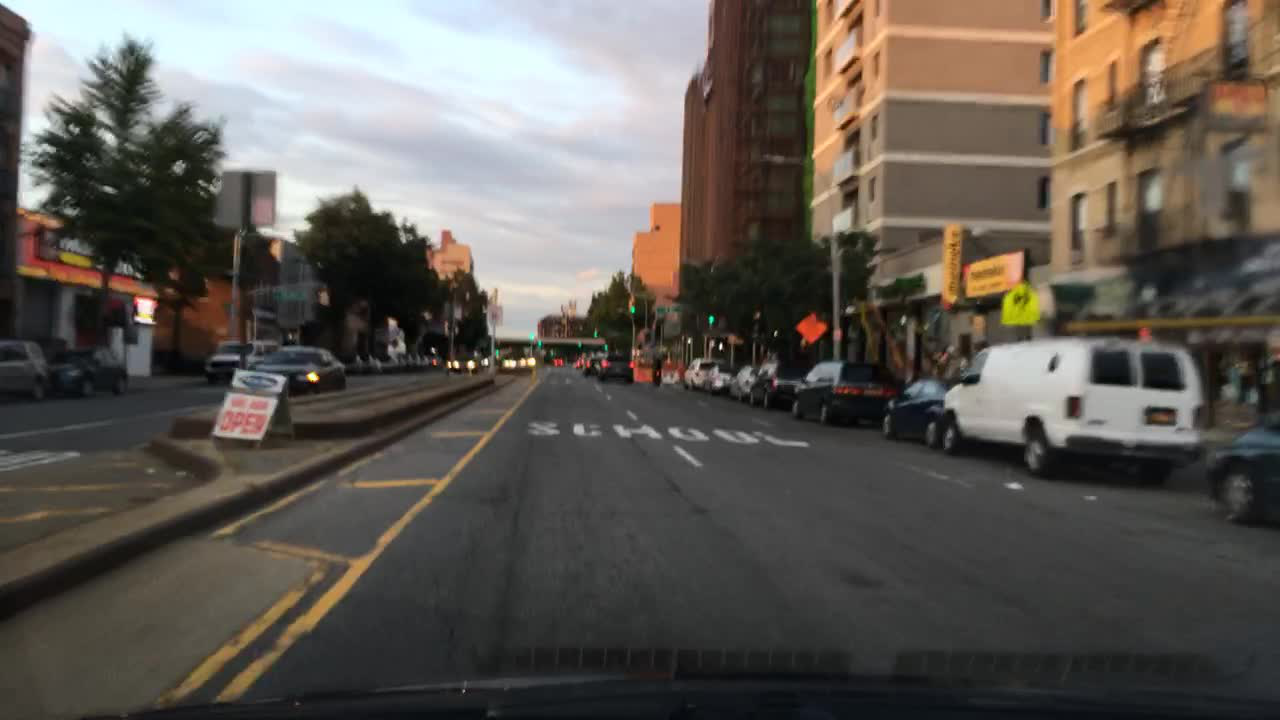

In [20]:
# pick one image from the test set
img_tensor, _ = dataset_val[0]
img = Image.fromarray(img_tensor.mul(255).permute(1, 2, 0).byte().numpy())
img

Single inference took 0.09123897552490234 seconds


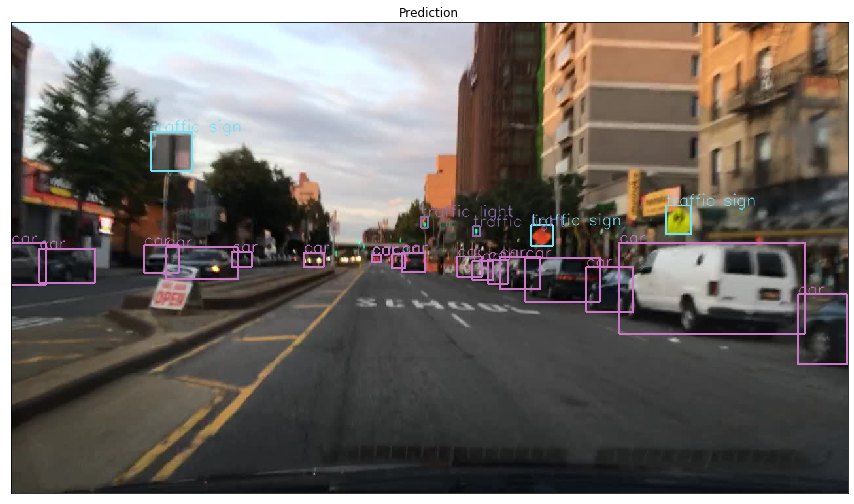

In [24]:
model.eval()
model.cuda()

start = time.time()
with torch.no_grad(): pred = model([img_tensor.to(device)])
print('Single inference took {} seconds'.format(time.time()-start))
total_preds = threshold_preds(pred)
pred_img = prediction2image(img_tensor, pred)

plt.figure(figsize=(15,10))
visualize(prediction=pred_img)

Single inference took 0.0740046501159668 seconds


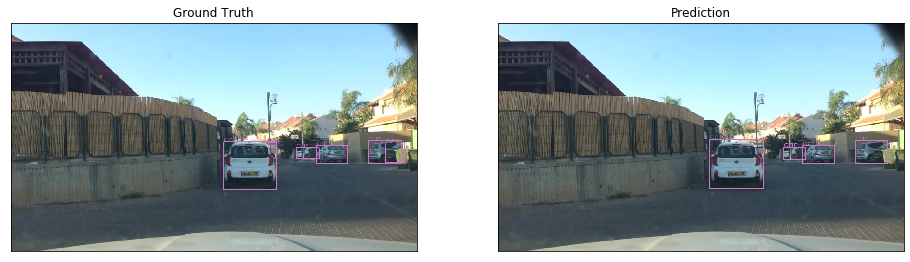

Single inference took 0.07423877716064453 seconds


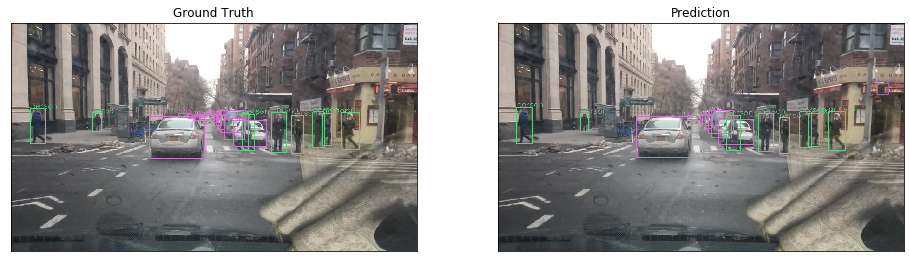

Single inference took 0.07428836822509766 seconds


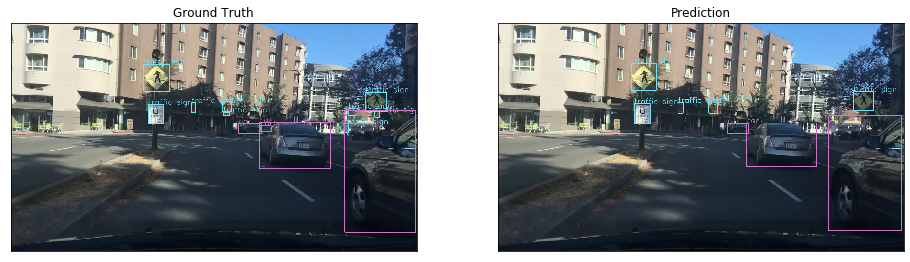

Single inference took 0.07456040382385254 seconds


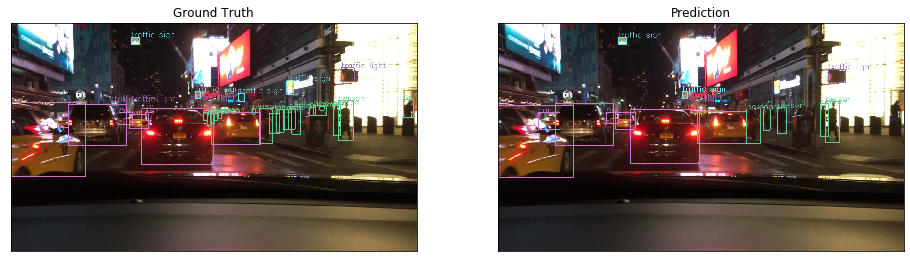

Single inference took 0.07419037818908691 seconds


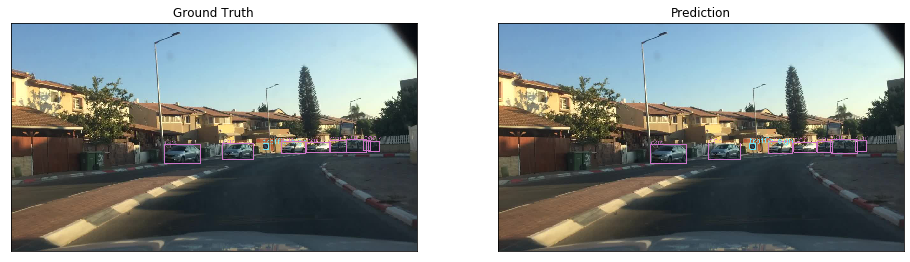

In [25]:
ids = np.random.choice( np.arange(len(dataset_val)), size=5 )

for i in ids:
    img_tensor, target = dataset_val[i]
    start = time.time()
    with torch.no_grad(): pred = model([img_tensor.to(device)])
    print('Single inference took {} seconds'.format(time.time()-start))
    total_preds = threshold_preds(pred)

    gt_img = labels2image(img_tensor, target)
    pred_img = prediction2image(img_tensor, pred)

    plt.figure(figsize=(16,5))
    visualize(ground_truth=gt_img, prediction=pred_img)

## Test on a video stream

In [26]:
PATH_TO_VIDEO = '/home/ruslan/Desktop/moscow_streets.mp4'
vs = cv2.VideoCapture(PATH_TO_VIDEO)
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

FPS = []
while(1):
# for i in tqdm( range(50) ):
    # get raw frames from video stream
    ret, frame_raw = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start_preprocess = time.time()
    img_tensor = torchvision.transforms.ToTensor()(frame_raw);
    # predict detection from the frame
    start_prediction = time.time()
    with torch.no_grad():
        pred = model([img_tensor.to(device)])
    end = time.time()
    dt = end - start_preprocess #start_prediction
    FPS.append(1./dt)
    # print("[INFO] single frame took {:.4f} seconds".format(dt))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('output.avi', fourcc, 30, (frame_raw.shape[1], frame_raw.shape[0]), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start_preprocess)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # write the output frame to disk
    output_to_write = prediction2image(img_tensor, pred)
    writer.write(output_to_write) # should be of shape (h x w x 3), type=np.uint8 (0..255)
    
#     visualize(
#         image=denormalize(frame.squeeze()[:,:,(2,1,0)]),
#         pr_mask=pr_mask.squeeze(),
#         seg_output=output_to_write,
#     )

print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))


[INFO] 12911 total frames in video
[INFO] single frame took 0.0887 seconds
[INFO] estimated total time: 19.0812 [min]
[INFO] Mean FPS 15.6704 Hz


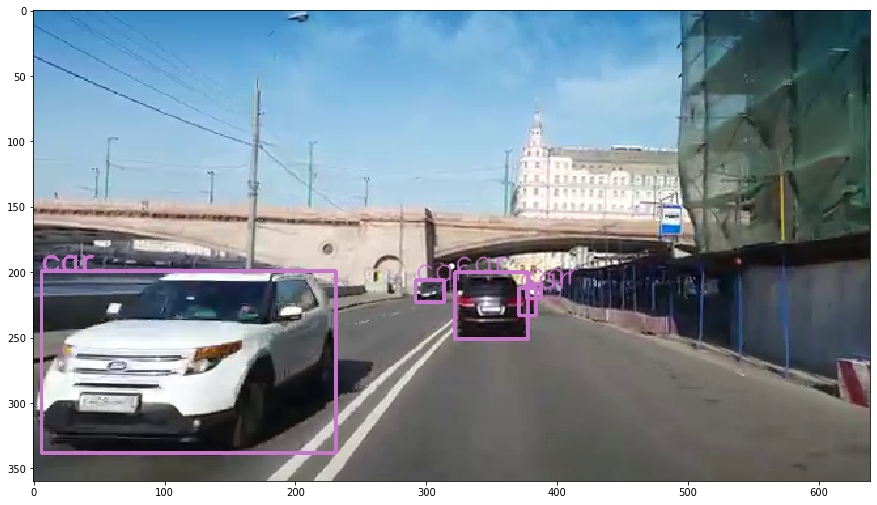

In [27]:
plt.figure(figsize=(15,10))
plt.imshow(output_to_write[...,(2,1,0)]);